# Baysian Two-way Fixed Effects

- 階層ベイズモデル 不均一分散
- GLMM 不均一分散
- GLM 均一分散

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## TWFE

$$
\log{Y^*_{it}} = \log{Y_{it}} - \bar{\log{{Y}_{i}}}
$$

$$
\begin{aligned}
\log{Y^*_{it}} &\sim \mathcal{t}(\nu, \mu_{it}, \sigma^2) \\
\mu_{it} &= \beta \cdot T_{it} \\
\beta &\sim \mathcal{N}(0, 1) \\
\nu &\sim \mathcal{Exponential}(\lambda = 1/10) \\
\sigma &\sim \mathcal{Cauchy}^+(\beta=1) \\
\end{aligned}
$$

## 階層ベイズモデル 不均一分散

In [7]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    sigma_sigma = pm.HalfCauchy('sigma_sigma', beta=0.15)
    sigma = pm.HalfCauchy('sigma', beta=sigma_sigma, shape=n_islands)

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=0.1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = beta * treatment

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_ids], observed=df['log_pop_star'])

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [8]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
az.summary(trace_h_hetero, var_names=['beta', 'nu', 'sigma_sigma'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.029,0.009,0.012,0.046,0.000,0.000,1747.0,2883.0,1.0
nu,7.785,1.684,4.997,11.073,0.044,0.031,1546.0,2043.0,1.0
sigma_sigma,0.172,0.022,0.131,0.217,0.000,0.000,4373.0,2678.0,1.0


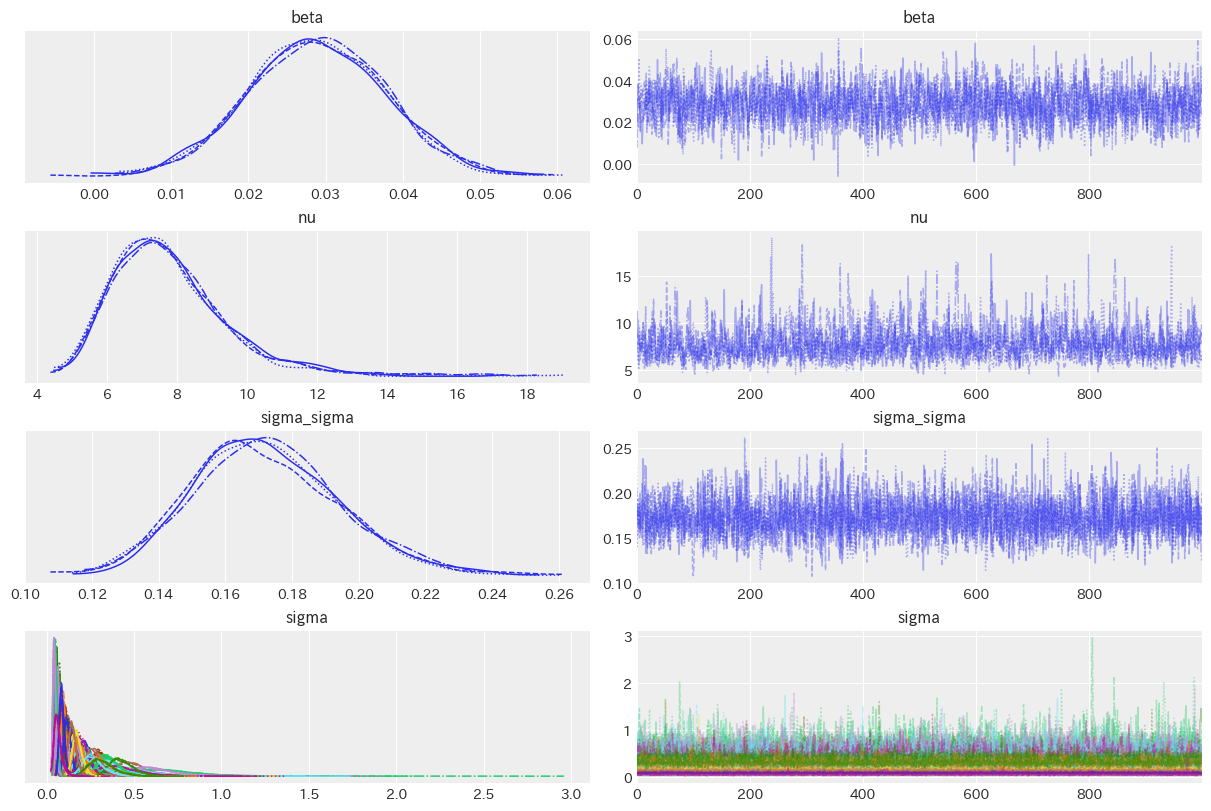

In [6]:
az.plot_trace(trace_h_hetero, var_names=['beta', 'nu', 'sigma_sigma', 'sigma']);

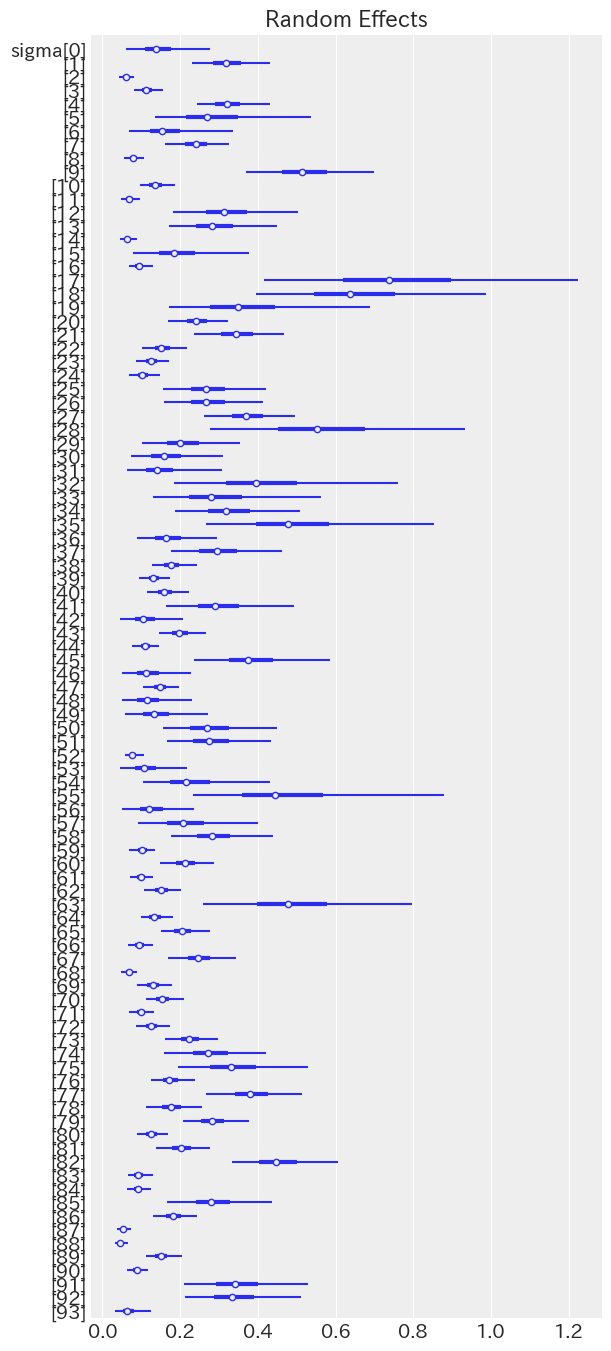

In [8]:
axes = az.plot_forest(
    trace_h,
    kind='forestplot',
    var_names=['sigma'],
    filter_vars='regex',
    combined=True,
    hdi_prob=.95
);
axes[0].set_title('Random Effects');

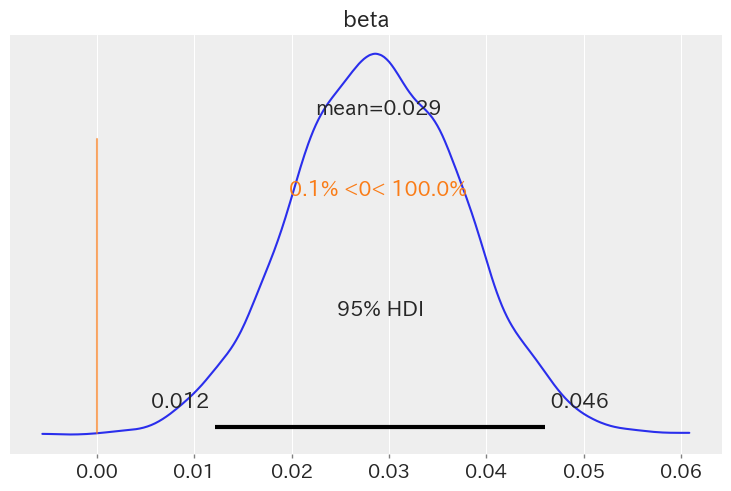

In [7]:
az.plot_posterior(trace_h_hetero, var_names=['beta'], ref_val=0, hdi_prob=.95);

In [24]:
sigma_df = az.summary(trace_h_hetero, var_names=['sigma'], hdi_prob=.95, kind='stats')

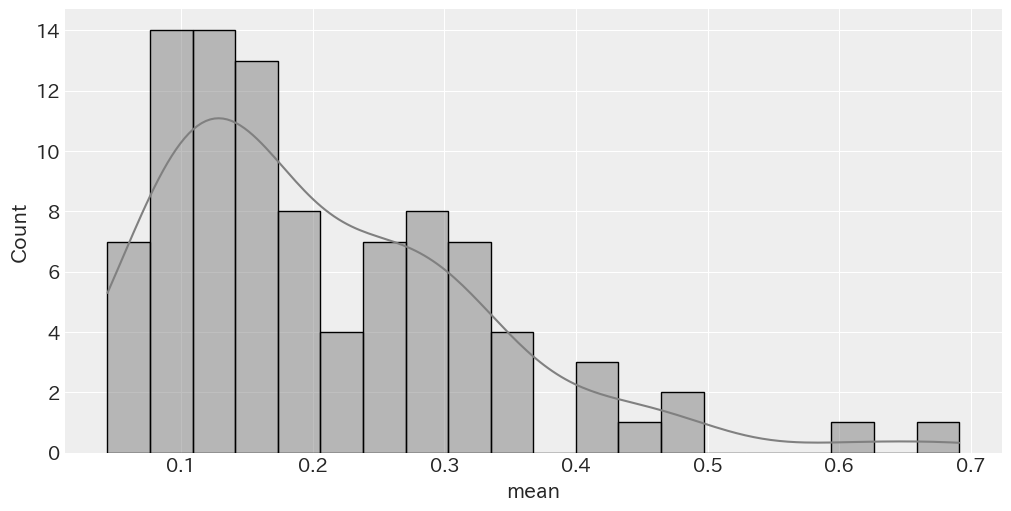

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(sigma_df['mean'], bins=20, kde=True, color='gray', label='95% HDI', ax=ax)
plt.show()

In [26]:
with model_h_hetero:
    pm.compute_log_likelihood(trace_h_hetero)
az.waic(trace_h_hetero)

Output()

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   477.51    43.47
p_waic       81.21        -

There has been a warning during the calculation. Please check the results.

In [11]:
# 欠損値の確認
print('欠損値の数:', df['log_pop_star'].isnull().sum())

# サンプリング後の補完値の取得
imputed_vales = trace_h_hetero.posterior.y_obs.stack(sample=('chain', 'draw')).mean(dim='sample')

欠損値の数: 140


In [122]:
imputed_vales = trace_h_hetero.posterior.y_obs.mean(dim=('chain', 'draw')).values

In [182]:
samples = trace_h_hetero.posterior.y_obs.stack(sample=('chain', 'draw'))
point_est = samples.mean(dim='sample')
hdi_lower = samples.quantile(0.025, dim='sample')
hdi_upper = samples.quantile(0.975, dim='sample')

results = pd.DataFrame({
    'real': df['log_pop_star'],
    'island_ids': df['island_ids'],
    'year': df['year'],
    'point_est': point_est,
    'hdi_lower': hdi_lower,
    'hdi_upper': hdi_upper,
})

In [207]:
# 欠損値のある行を取得
missing_island_ids = df[df['log_pop_star'].isnull()]['island_ids'].unique()
missing_island_ids

array([ 67,  68,  70,  72,  73,  91,  94,  99, 106, 111, 112, 113, 114,
       115, 116, 118, 119, 130, 132, 138, 139, 143, 144, 145, 153, 155,
       156, 157, 160, 162, 165, 170, 206, 216, 226])

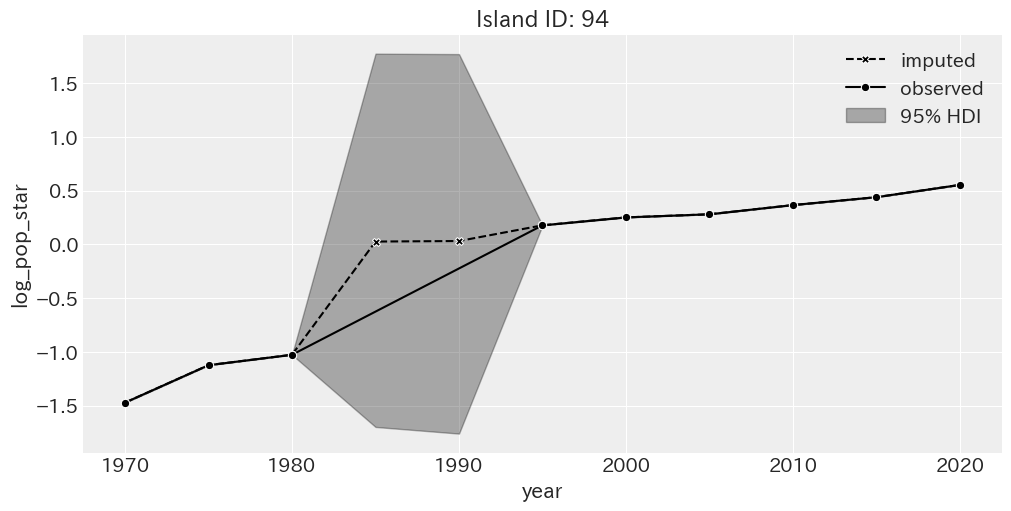

In [241]:
island_id = 94

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='year', y='point_est', data=results[results['island_ids'] == island_id], ax=ax, color='black', label='imputed', marker='X', linestyle='--')
sns.lineplot(x='year', y='real', data=results[results['island_ids'] == island_id], ax=ax, label='observed', color='black', marker='o')
ax.fill_between(
    results[results['island_ids'] == island_id]['year'],
    results[results['island_ids'] == island_id]['hdi_lower'],
    results[results['island_ids'] == island_id]['hdi_upper'],
    alpha=0.3,
    color='black',
    label='95% HDI'
)
ax.set_title(f'Island ID: {island_id}')
ax.set_ylabel('log_pop_star')
ax.legend()

/tmp/ipykernel_4962/592311940.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 5))


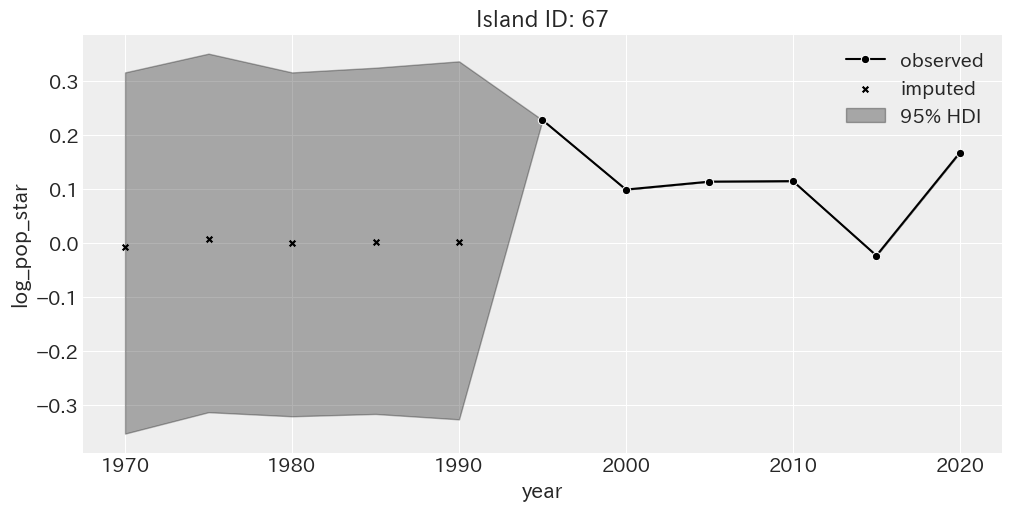

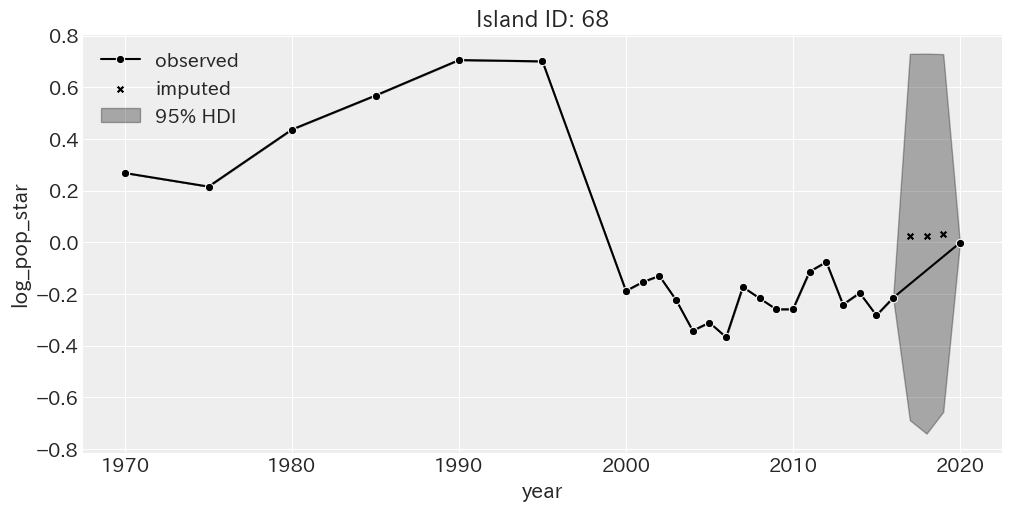

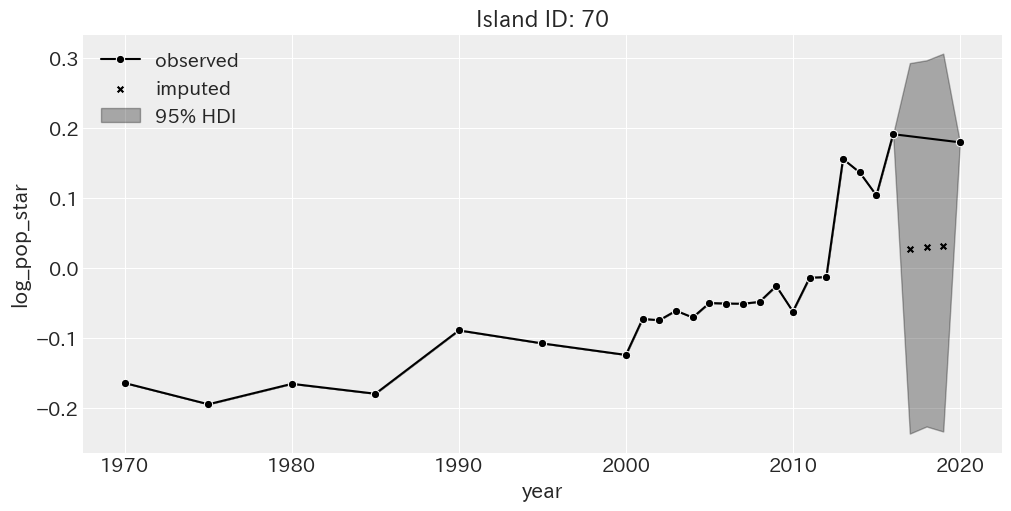

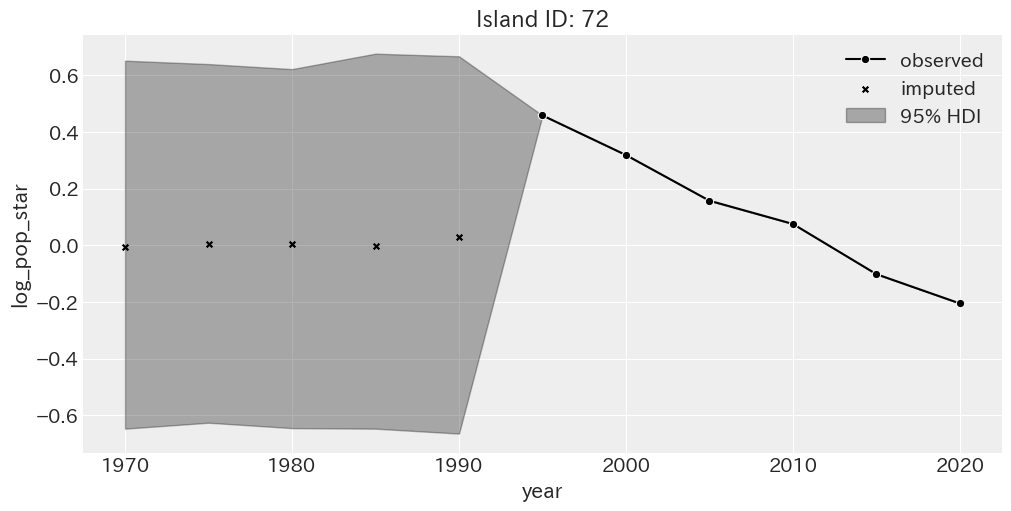

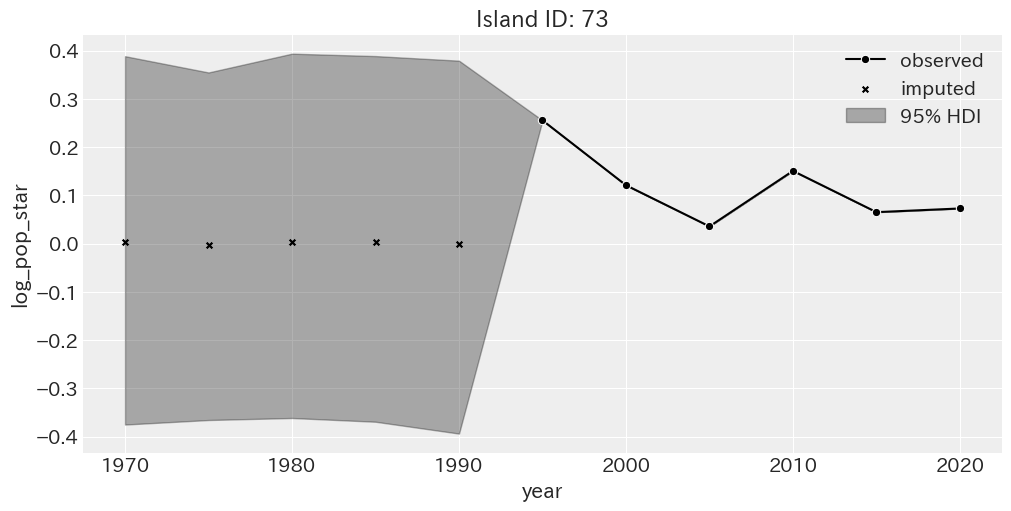

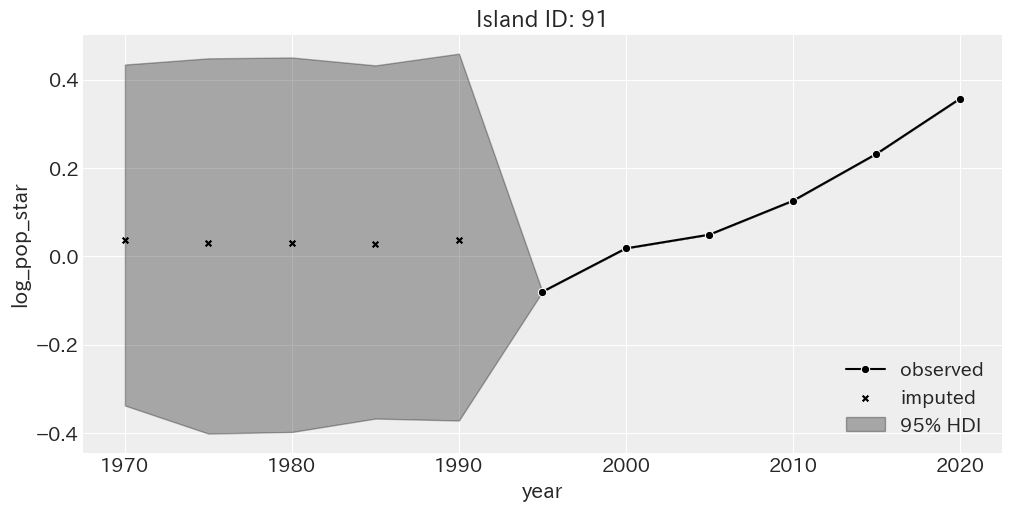

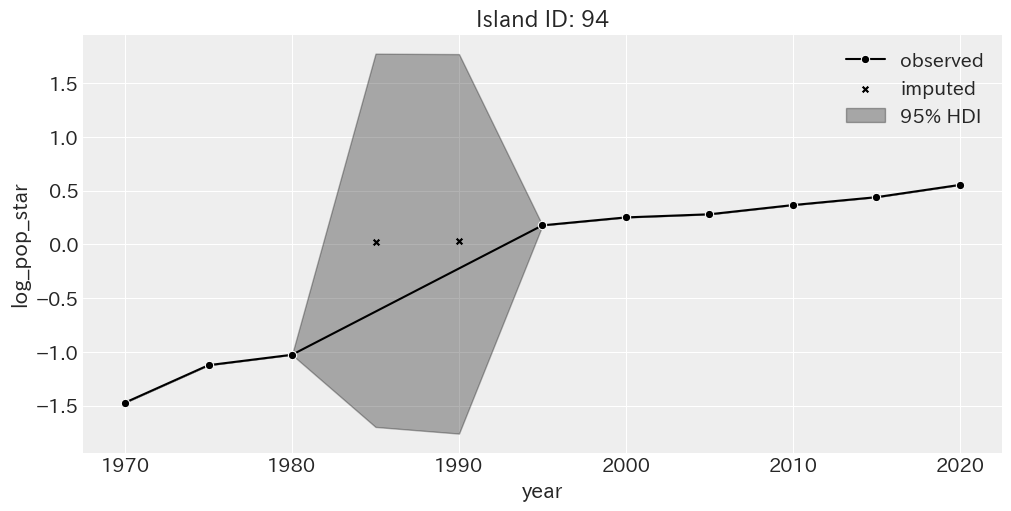

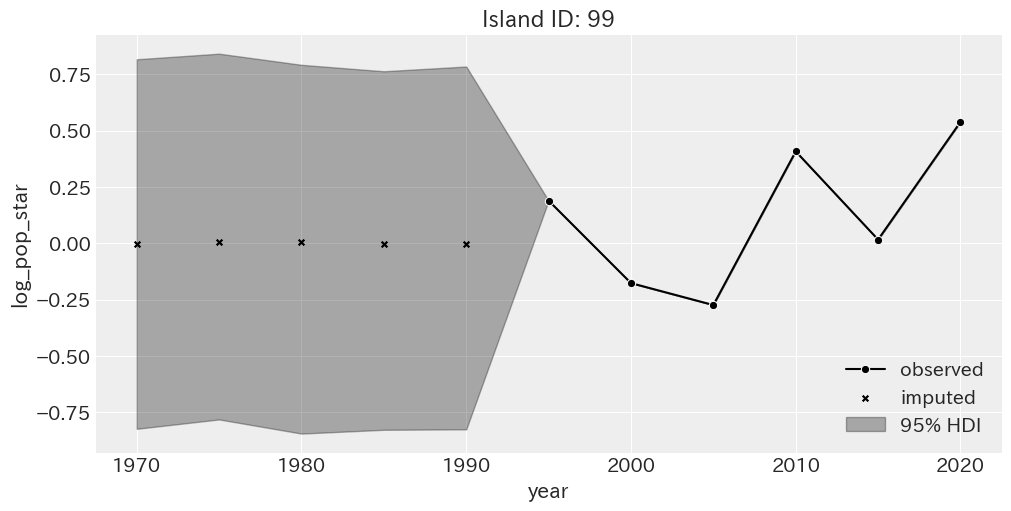

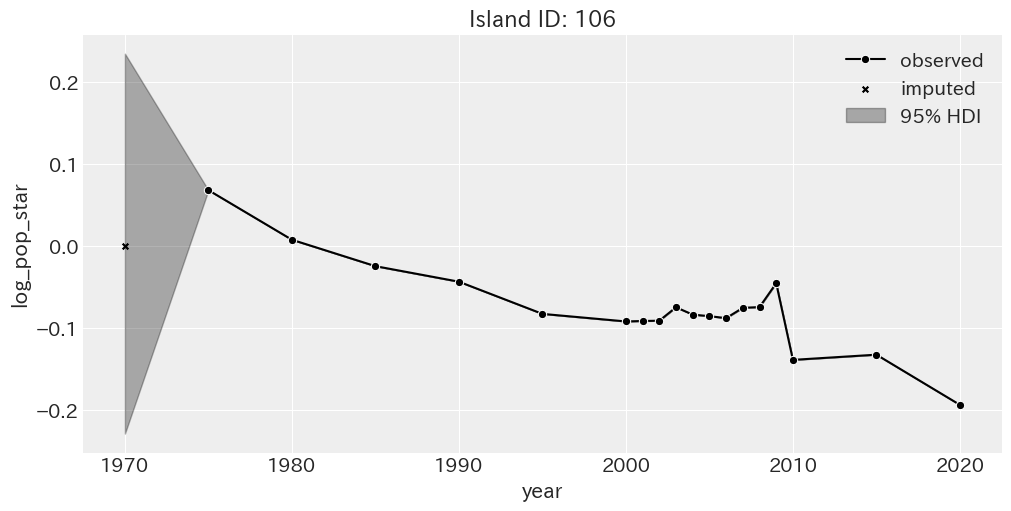

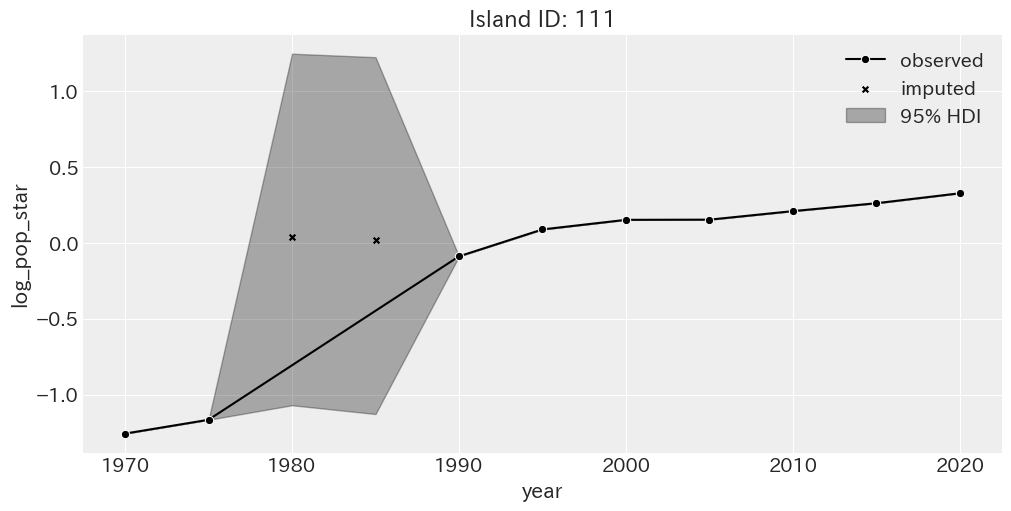

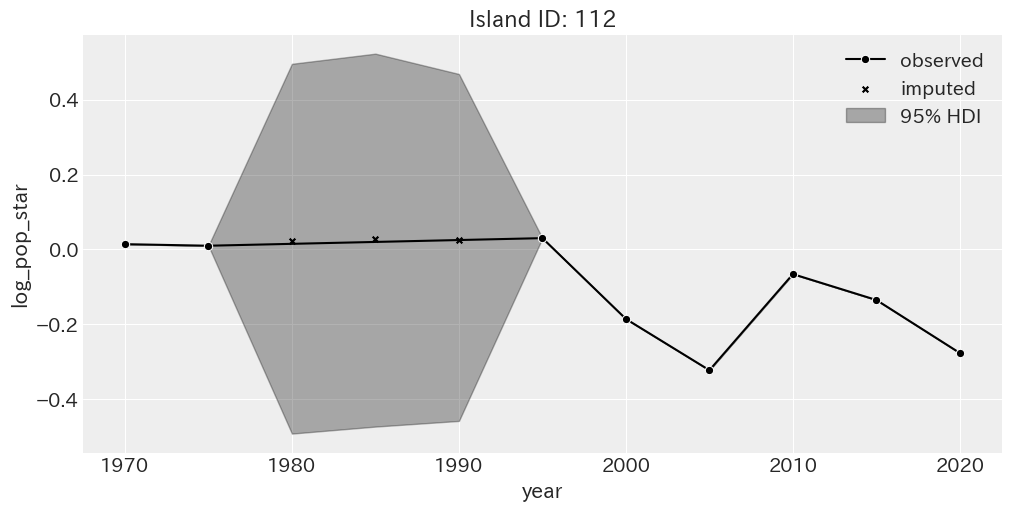

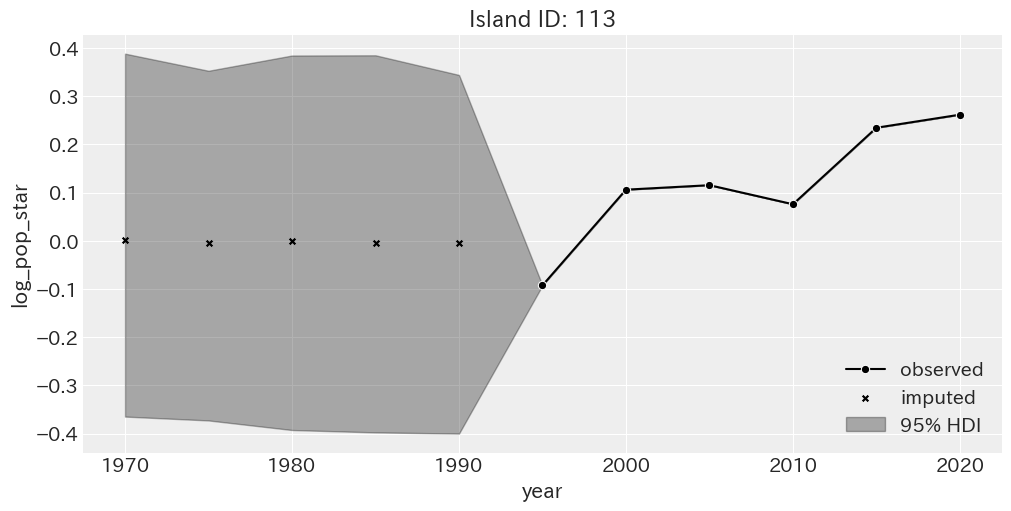

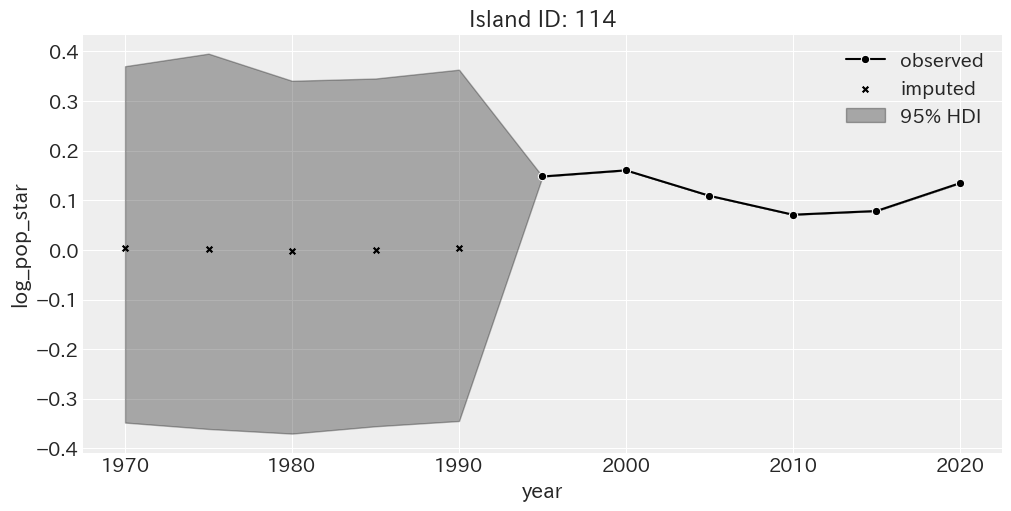

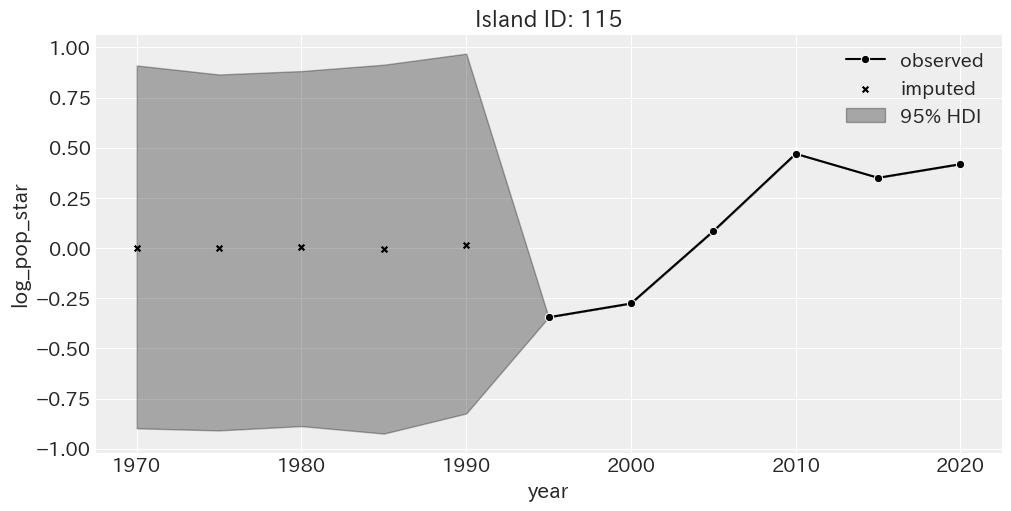

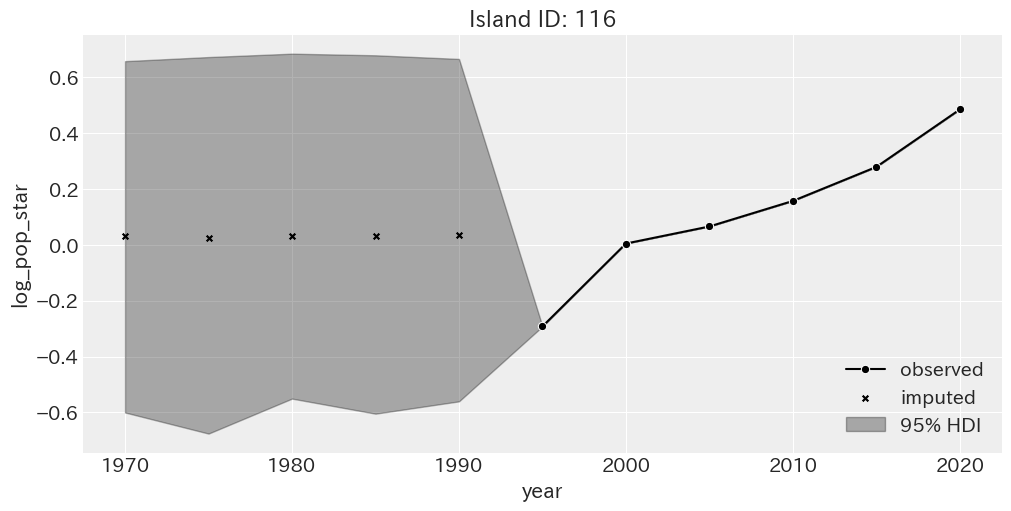

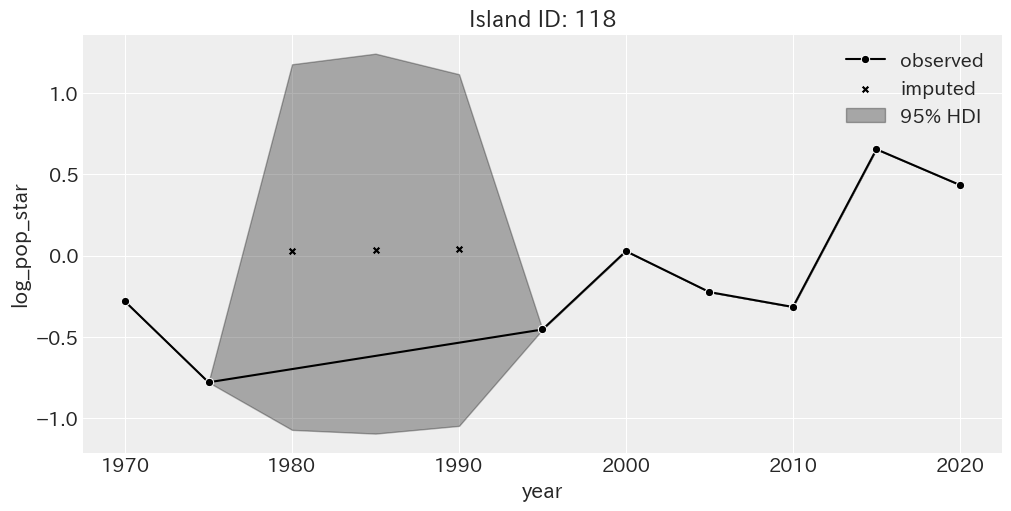

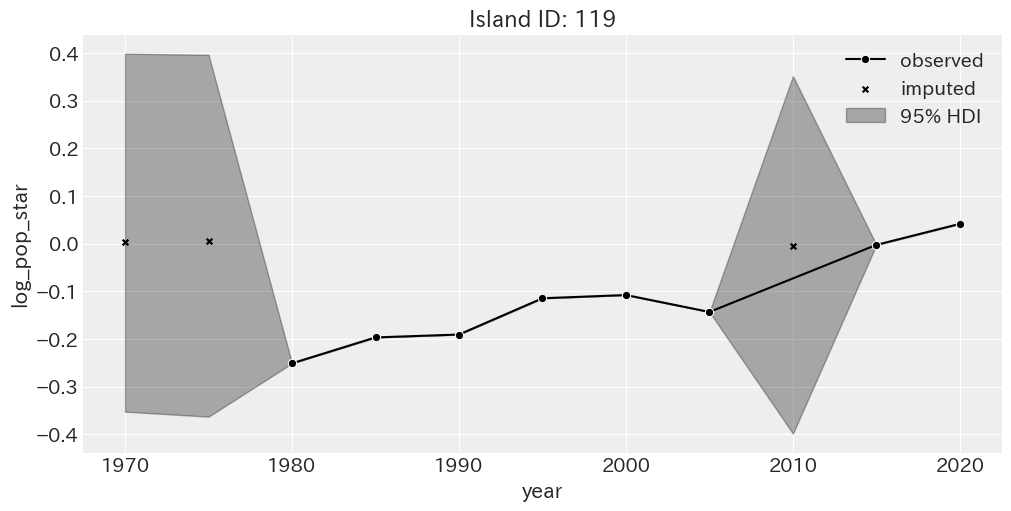

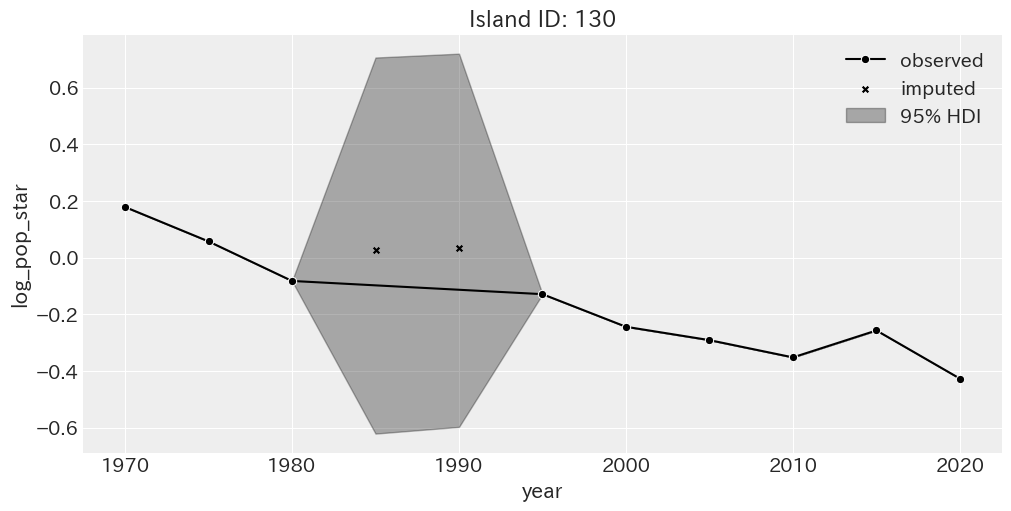

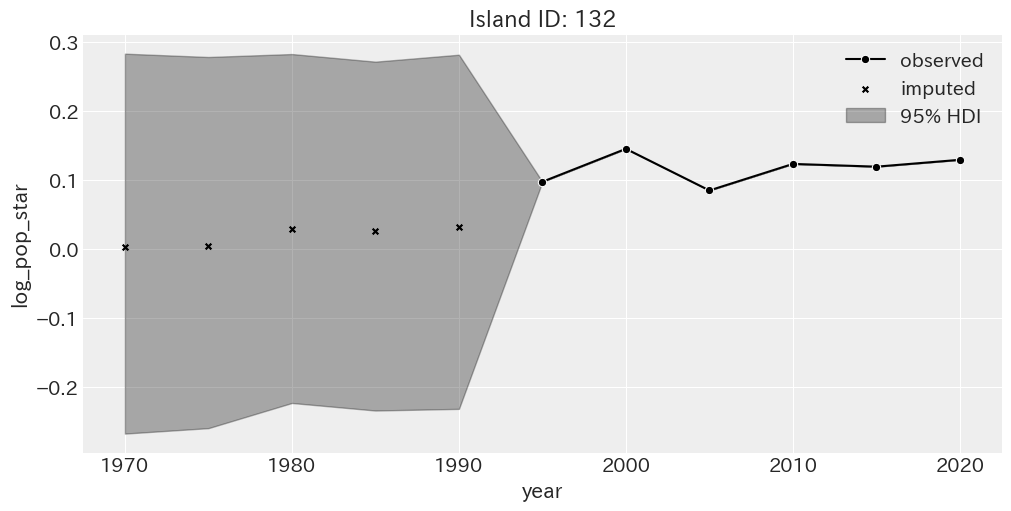

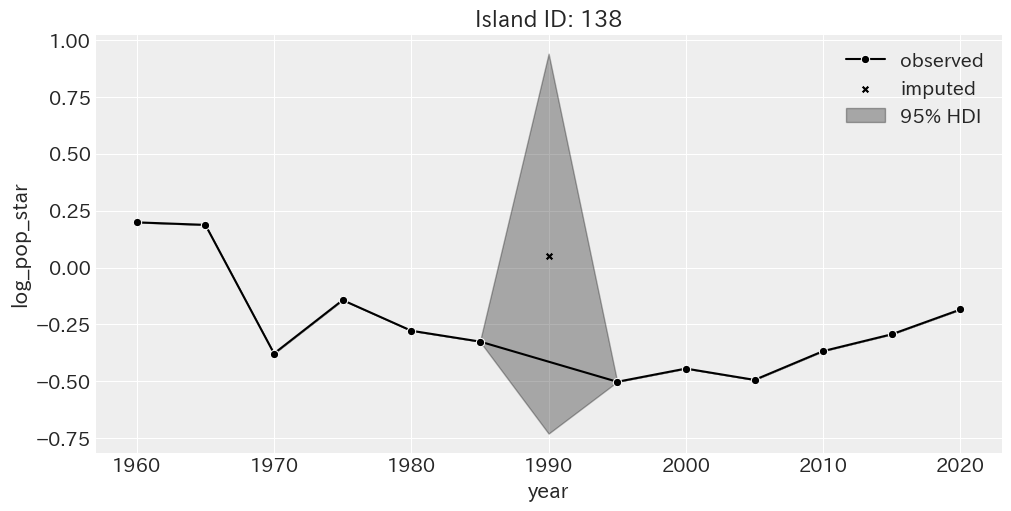

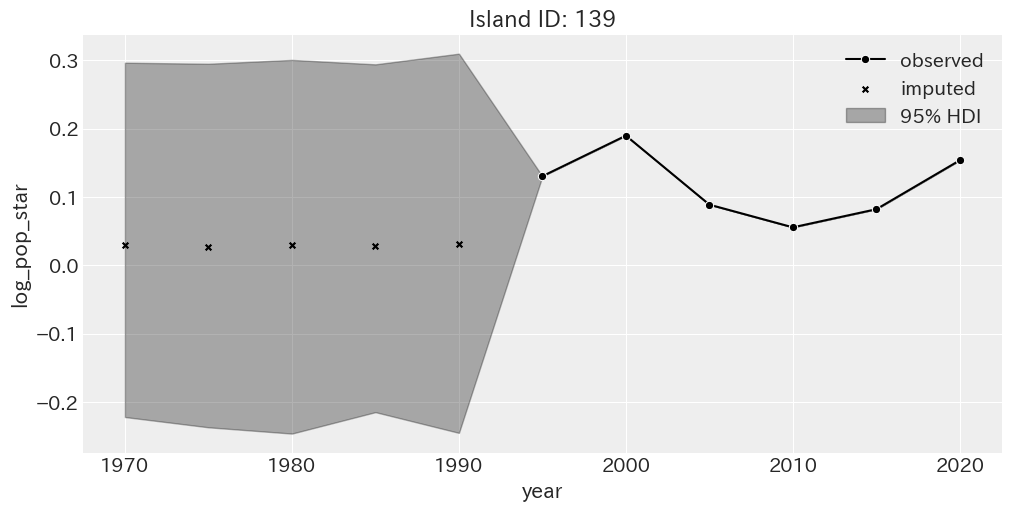

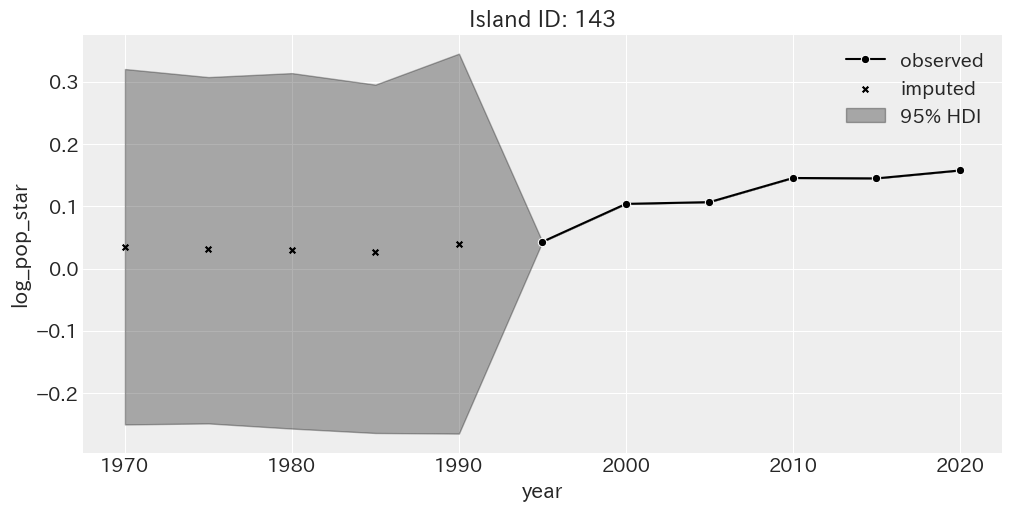

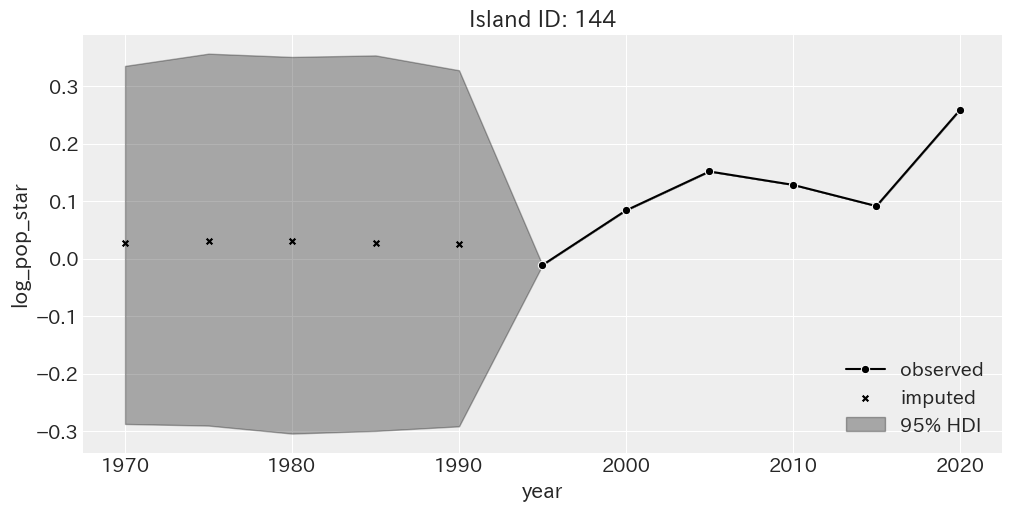

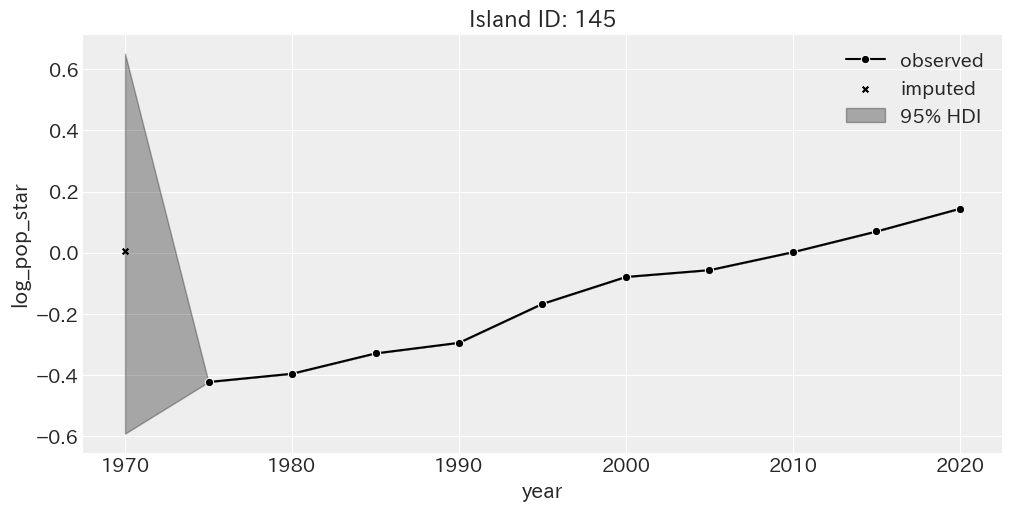

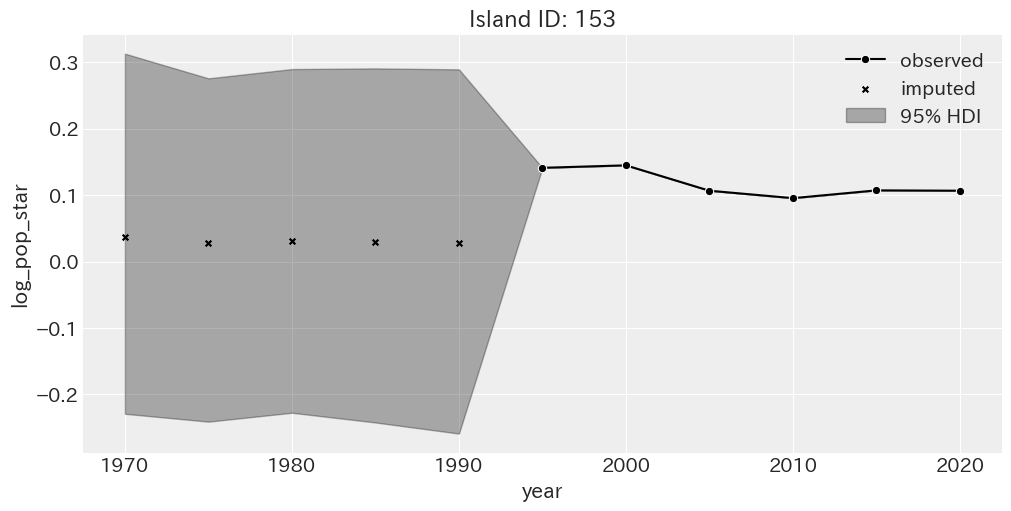

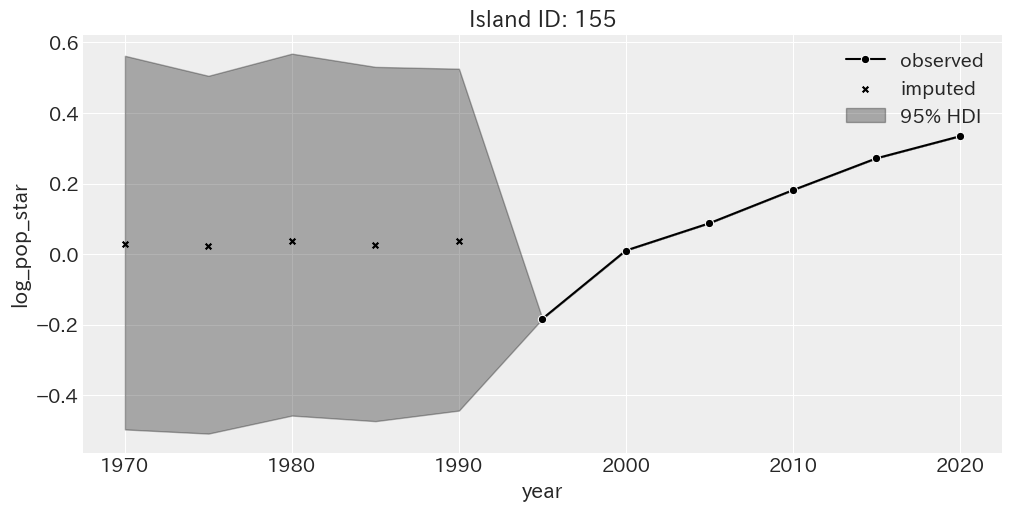

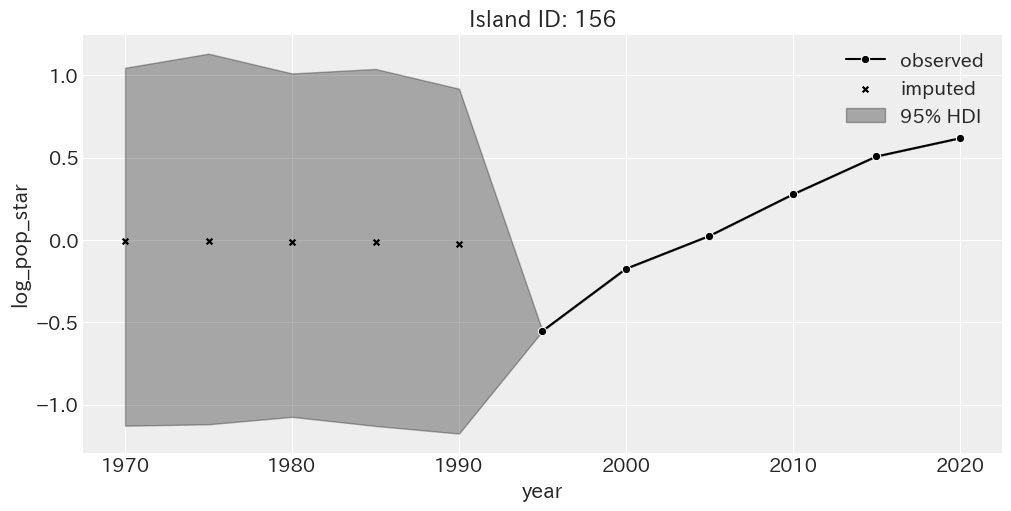

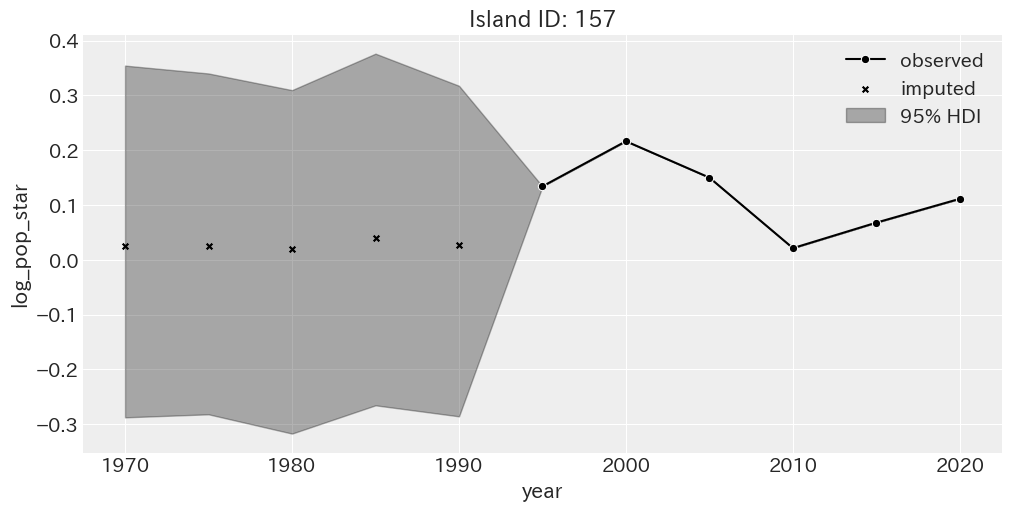

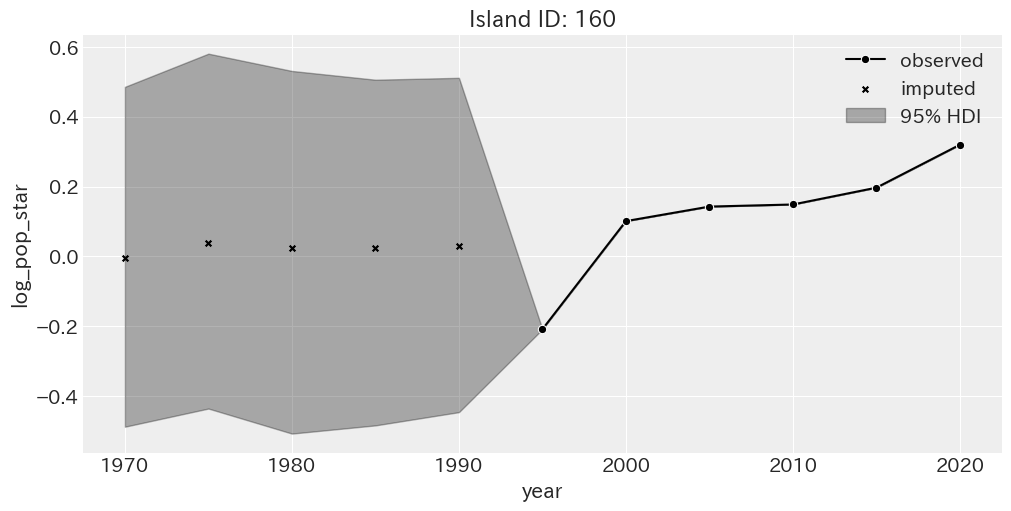

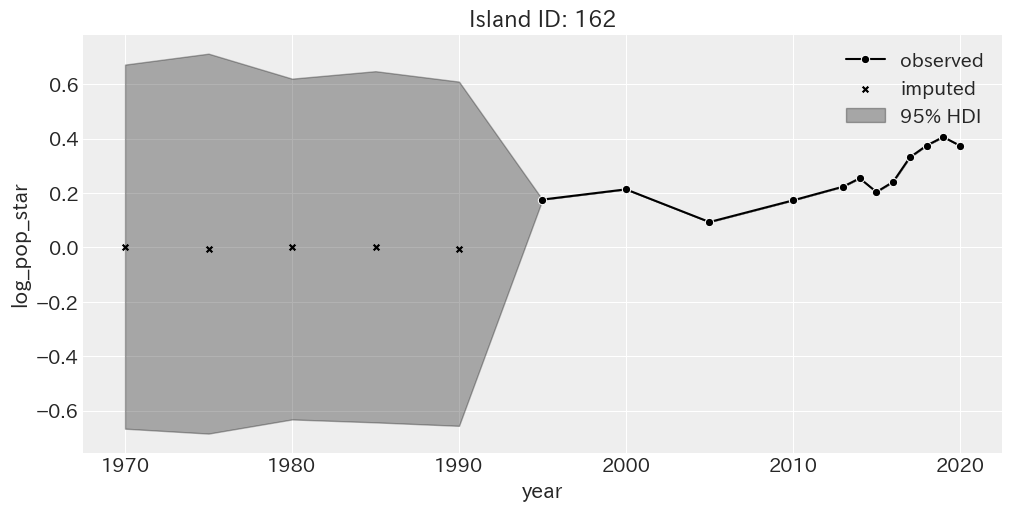

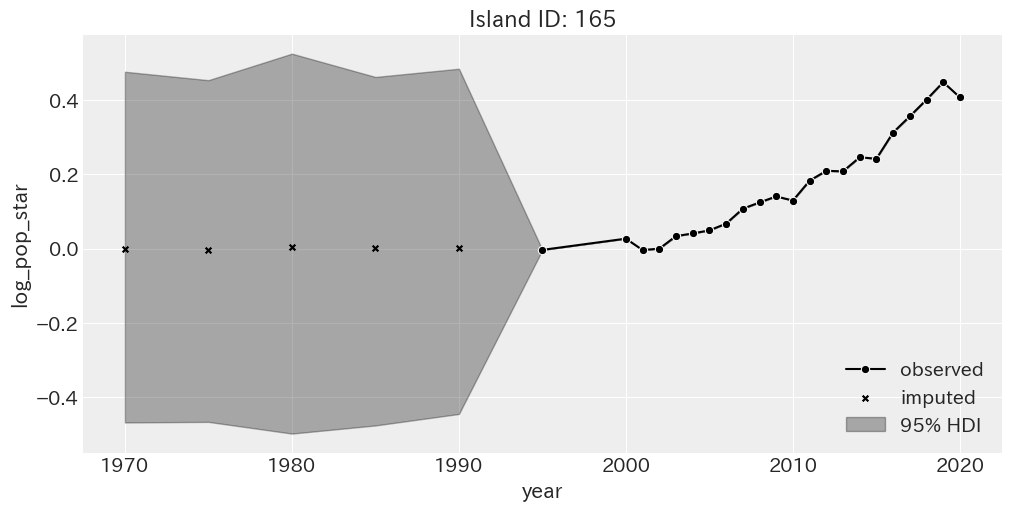

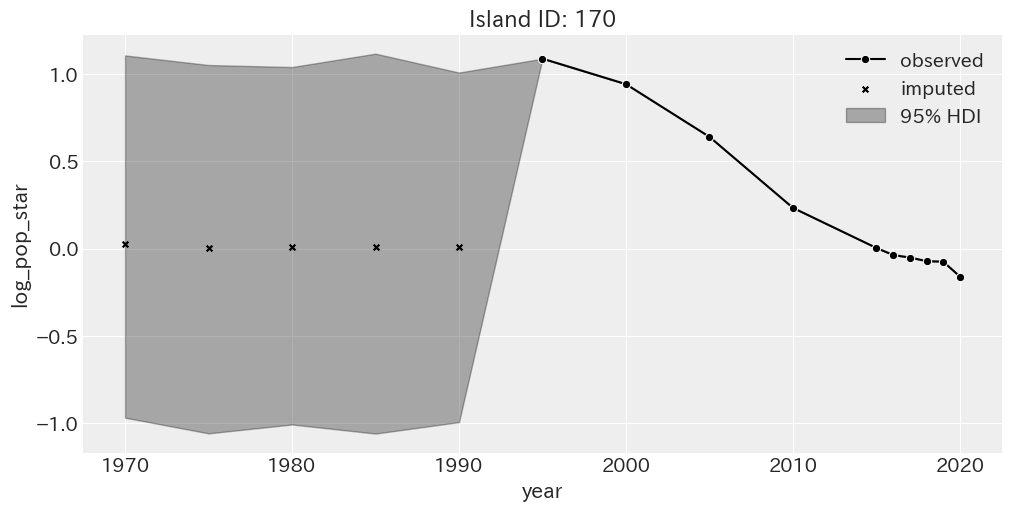

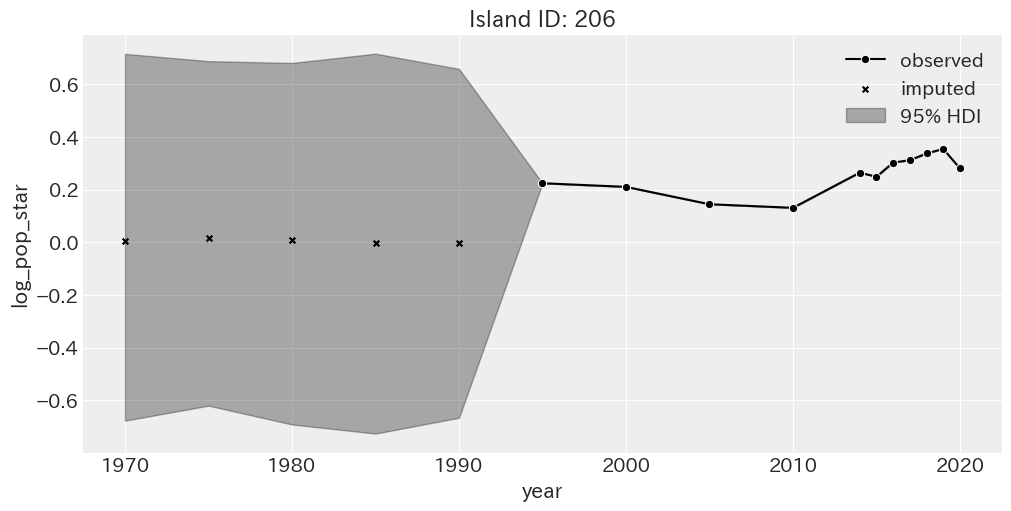

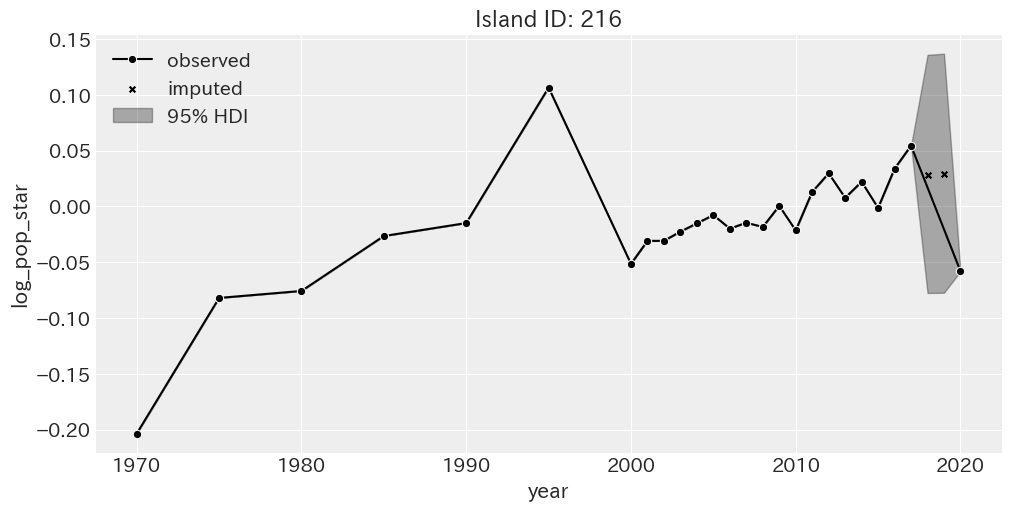

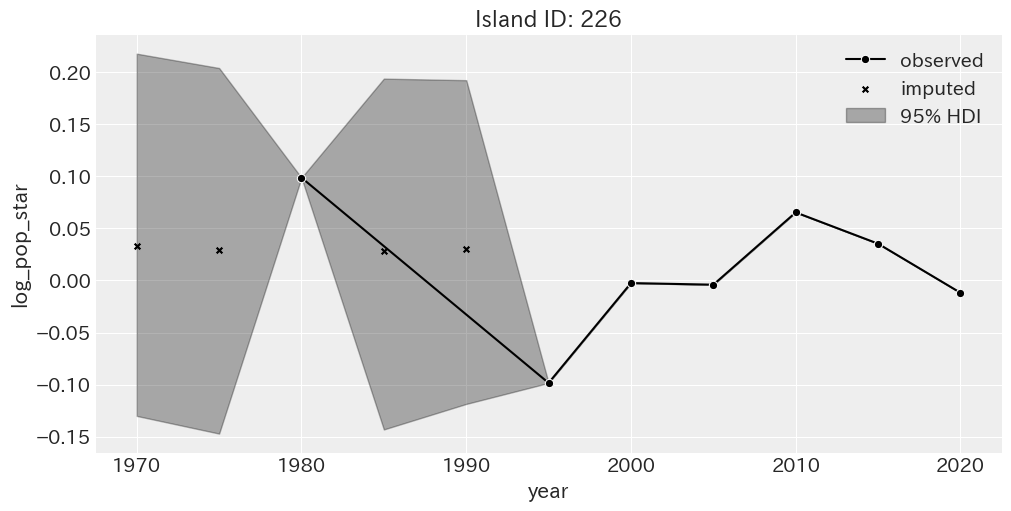

In [234]:
for island_id in missing_island_ids:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(x='year', y='real', data=results[results['island_ids'] == island_id], ax=ax, label='observed', color='black', marker='o')
    sns.scatterplot(x='year', y='point_est', data=results[results['island_ids'] == island_id], ax=ax, color='black', label='imputed', marker='X')
    ax.fill_between(
        results[results['island_ids'] == island_id]['year'],
        results[results['island_ids'] == island_id]['hdi_lower'],
        results[results['island_ids'] == island_id]['hdi_upper'],
        alpha=0.3,
        color='black',
        label='95% HDI'
    )
    ax.set_title(f'Island ID: {island_id}')
    ax.set_ylabel('log_pop_star')
    ax.legend()

## GLMM 不均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


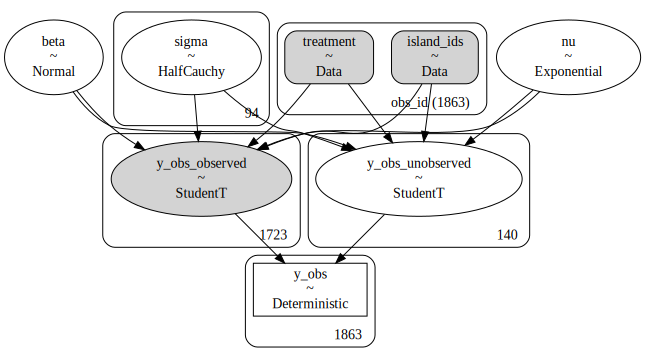

In [4]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    sigma = pm.HalfCauchy('sigma', beta=1, shape=n_islands)

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=1)
    nu = pm.Exponential('nu', lam=1/10)

    # expectation
    mu = beta * treatment

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_ids], observed=df['log_pop_star'])

pm.model_to_graphviz(model_h)

In [5]:
with model_h:
    trace_h = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
az.summary(trace_h, var_names=['beta', 'nu', 'sigma'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.028,0.009,0.009,0.045,0.000,0.000,1503.0,2031.0,1.0
nu,10.619,3.096,6.191,16.466,0.088,0.062,1350.0,1523.0,1.0
sigma[0],0.152,0.064,0.062,0.278,0.002,0.001,1350.0,1196.0,1.0
sigma[1],0.324,0.054,0.230,0.430,0.001,0.001,4191.0,2958.0,1.0
sigma[2],0.061,0.010,0.043,0.080,0.000,0.000,4234.0,3036.0,1.0
...,...,...,...,...,...,...,...,...,...
sigma[89],0.153,0.024,0.111,0.205,0.000,0.000,4356.0,3017.0,1.0
sigma[90],0.089,0.014,0.064,0.117,0.000,0.000,5031.0,2991.0,1.0
sigma[91],0.354,0.086,0.210,0.528,0.001,0.001,4903.0,2562.0,1.0
sigma[92],0.346,0.084,0.211,0.512,0.001,0.001,4718.0,3169.0,1.0


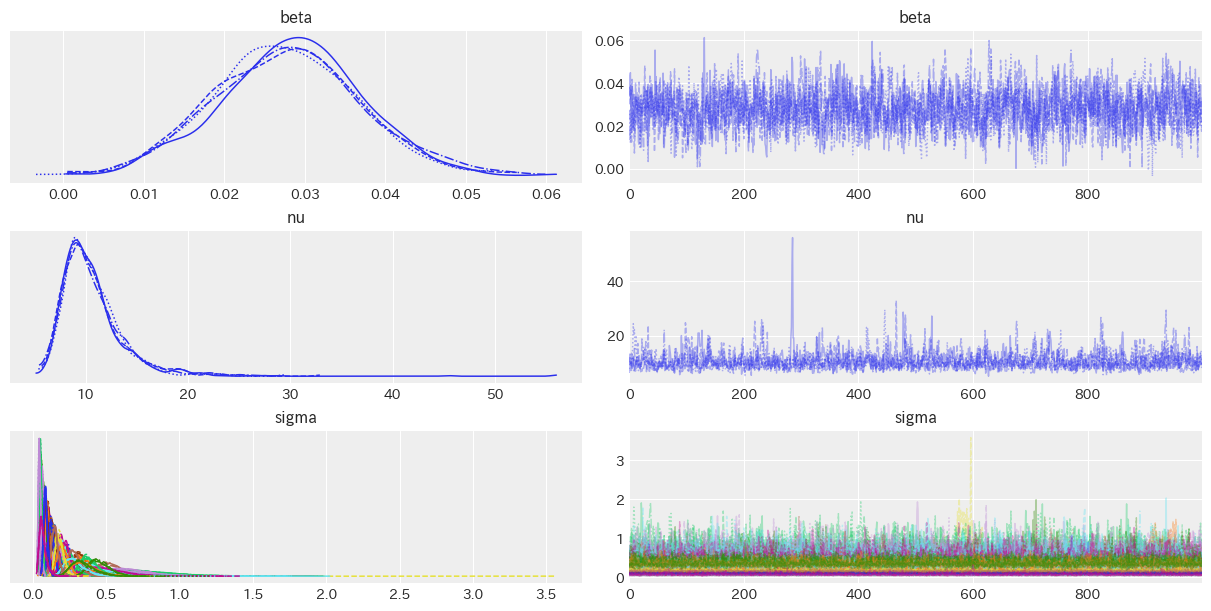

In [9]:
az.plot_trace(trace_h, var_names=['beta', 'nu', 'sigma']);

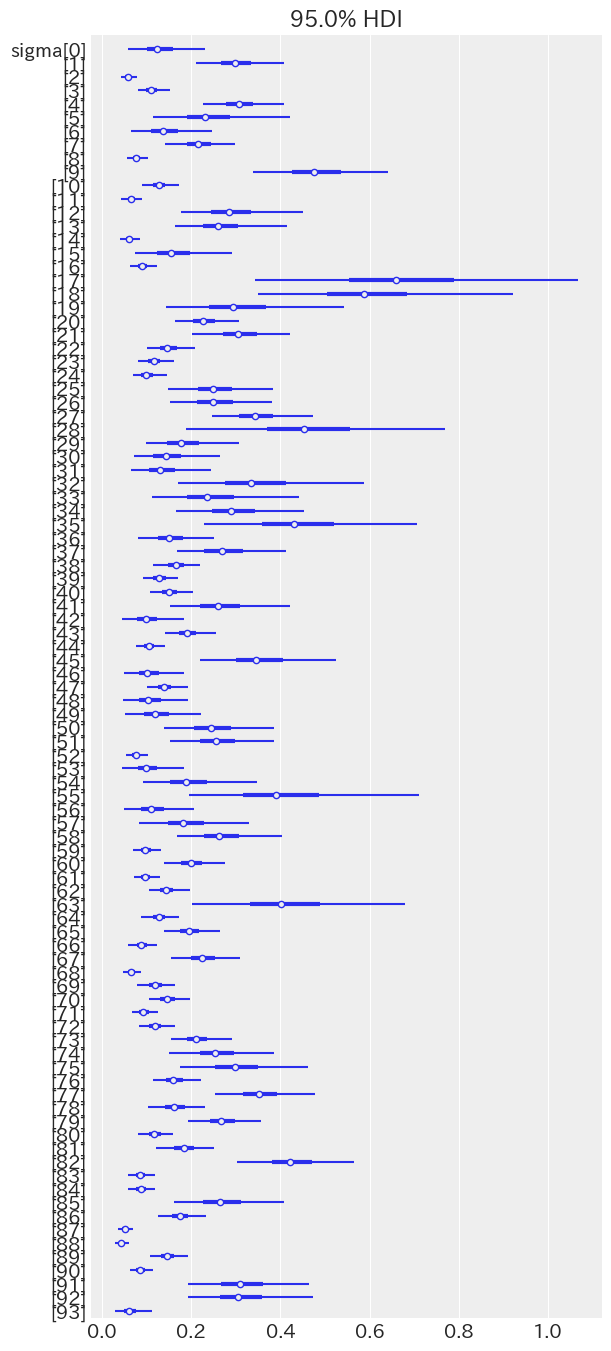

In [23]:
az.plot_forest(
    trace_h_hetero,
    kind='forestplot',
    var_names=['sigma'],
    combined=True,
    hdi_prob=.95
);

In [12]:
with model_h:
    pm.compute_log_likelihood(trace_h)

Output()

In [13]:
az.waic(trace_h)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   471.15    42.32
p_waic       83.64        -

There has been a warning during the calculation. Please check the results.

## GLMM 均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


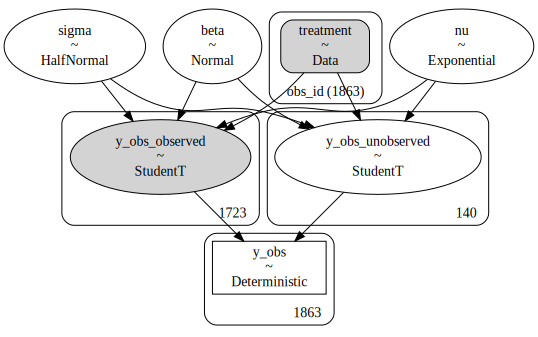

In [4]:
COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model:
    # data
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=0.3)
    nu = pm.Exponential('nu', lam=1/10)
    sigma = pm.HalfNormal('sigma', sigma=0.24) # y_std = df['log_pop_star'].std() = 0.242

    # expectation
    mu = beta * treatment

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_star'])

pm.model_to_graphviz(model)

In [5]:
with model:
    trace = pm.sample(
        draws=1000,
        tune=500,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [6]:
az.summary(trace, hdi_prob=.95, var_names=['beta', 'nu', 'sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,-0.006,0.009,-0.024,0.010,0.000,0.000,7619.0,3327.0,1.0
nu,2.849,0.226,2.420,3.292,0.004,0.003,3348.0,2509.0,1.0
sigma,0.147,0.005,0.138,0.157,0.000,0.000,3843.0,3272.0,1.0


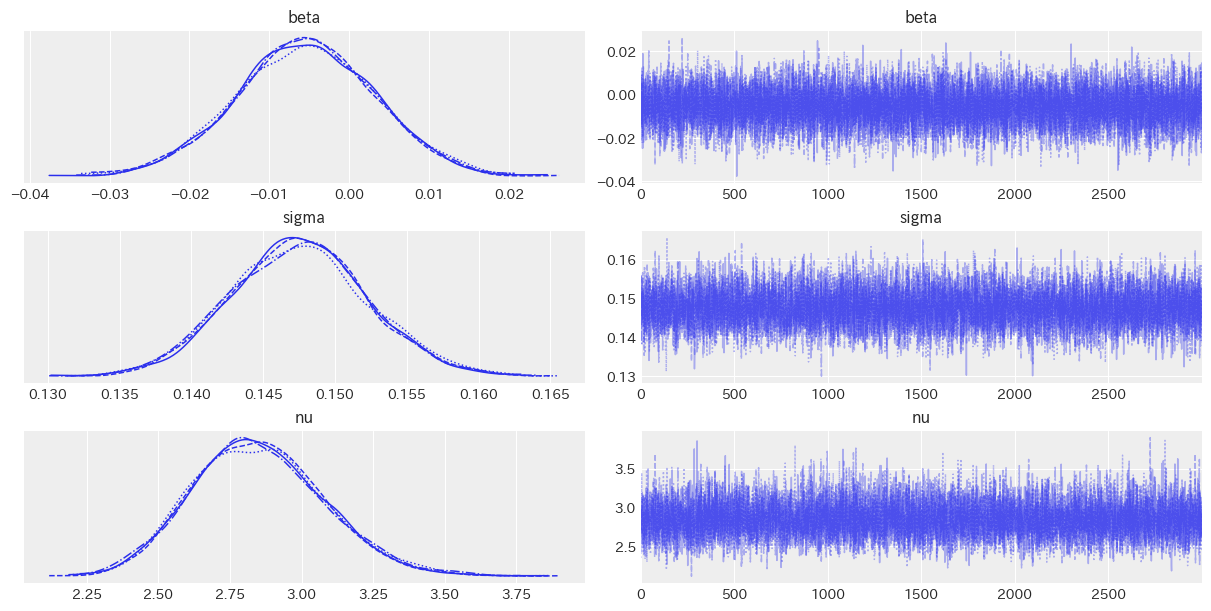

In [12]:
az.plot_trace(trace, var_names=['beta', 'sigma', 'nu']);

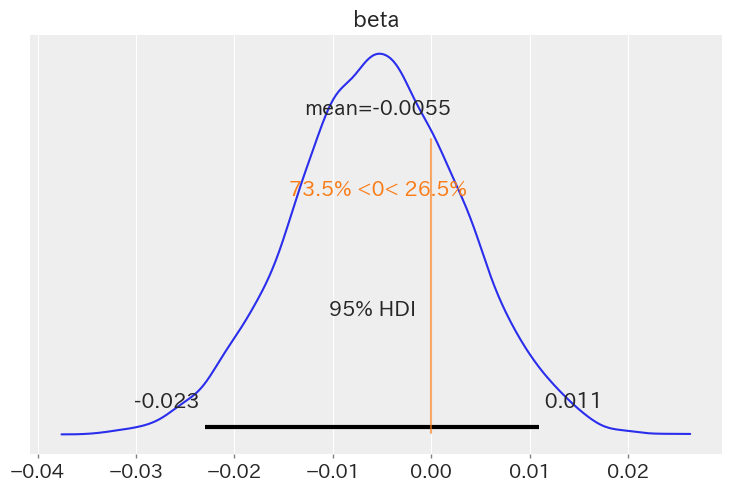

In [13]:
az.plot_posterior(trace, var_names=['beta'], ref_val=0, hdi_prob=.95);

In [14]:
with model:
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Output()

Sampling: [y_obs_observed]


Output()

In [15]:
az.waic(trace)

Computed from 12000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   203.60    44.88
p_waic        3.06        -

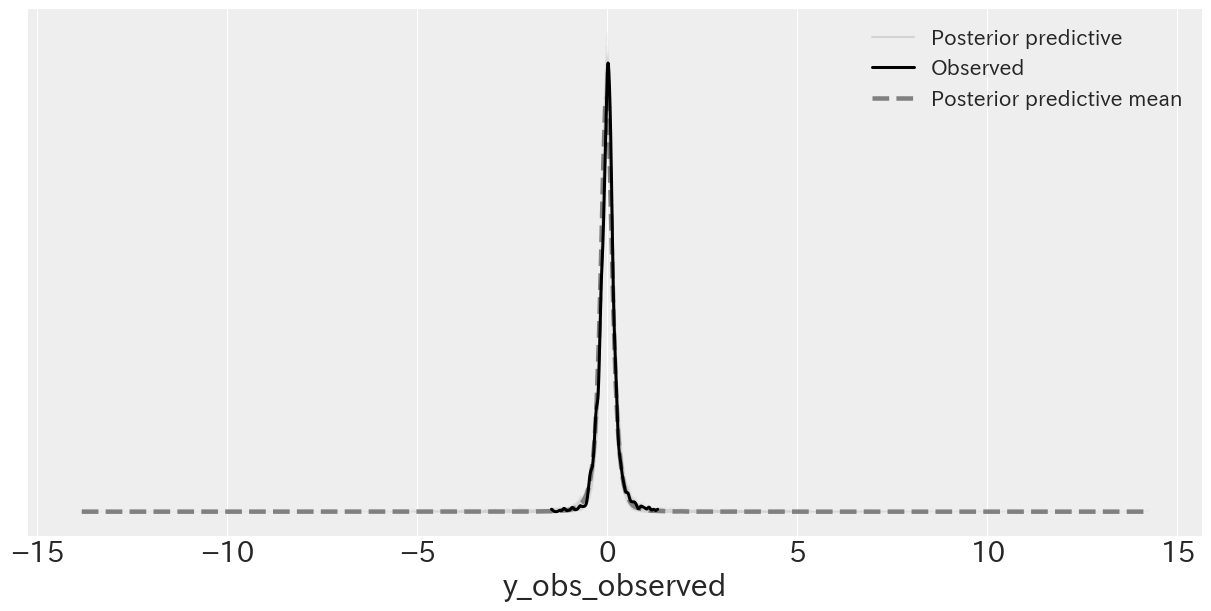

In [60]:
az.plot_ppc(
    trace,
    num_pp_samples=100,
    kind='kde',
    figsize=(12, 6),
    colors=('lightgray', 'black', 'gray')
);

## サンプリングの保存

In [ ]:
# az.to_netcdf(trace, './mcmc_sample/twfe/twfe.nc')